In [ ]:
# import packages

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [2]:
# Load datasets
ratings_path = '/Users/np-bri-mbp-01/Downloads/Assignment/ratings.csv'
movies_path = '/Users/np-bri-mbp-01/Downloads/Assignment/movies.csv'
tags_path = '/Users/np-bri-mbp-01/Downloads/Assignment/tags_cleaned.csv'

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from flask import Flask, render_template, request

# app = Flask(__name__)

# Load datasets
ratings_path = '/Users/np-bri-mbp-01/Downloads/Assignment/ratings.csv'
movies_path = '/Users/np-bri-mbp-01/Downloads/Assignment/movies.csv'
tags_path = '/Users/np-bri-mbp-01/Downloads/Assignment/tags_cleaned.csv'

ratings = pd.read_csv(ratings_path, nrows=100000)
movies = pd.read_csv(movies_path)
tags = pd.read_csv(tags_path)

# Merge ratings with movies and tags
merged_data = pd.merge(ratings, movies, on='movieId')
merged_data = pd.merge(merged_data, tags, on=['userId', 'movieId'], how='left')

def apply_pca(X):
    pca = PCA(n_components=min(X.shape[1], 2))  # Ensure n_components <= number of features
    X_pca = pca.fit_transform(X)
    return X_pca

def categorize_ratings(rating):
    if rating <= 2.0:
        return 'Low'
    elif rating <= 3.5:
        return 'Medium'
    else:
        return 'High'

merged_data['rating_category'] = merged_data['rating'].apply(categorize_ratings)

X = merged_data[['userId', 'movieId']]
y = merged_data['rating_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def classify_ratings(X_train, X_test, y_train, y_test):
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of Decision Tree Classifier: {accuracy:.2f}')
    return clf

clf = classify_ratings(X_train, X_test, y_train, y_test)

def cluster_users(X, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    return kmeans

X_pca = apply_pca(X[['userId', 'movieId']])
kmeans_model = cluster_users(X_pca)

def get_movie_recommendation(movie_title, num_recommendations=8):
    movie_id = movies[movies['title'].str.contains(movie_title, case=False, na=False)]['movieId'].values
    if len(movie_id) == 0:
        return f"Movie '{movie_title}' not found in the database."
    
    movie_id = movie_id[0]
    
    similar_tags = tags[tags['movieId'] == movie_id]['tag'].tolist()
    similar_movies = tags[tags['tag'].isin(similar_tags)]
    
    if similar_movies.empty:
        return f"No similar movies found for '{movie_title}'."
    
    popular_movies = similar_movies.groupby('movieId').size().sort_values(ascending=False).head(num_recommendations)
    recommendations = pd.merge(popular_movies.reset_index(), movies, on='movieId')[['title', 'movieId']]
    
    recommendations_text = f"Recommendations based on your interest in '{movie_title}':<br>"
    for i, row in recommendations.iterrows():
        recommended_movie_id = row['movieId']
        recommended_movie_tags = tags[tags['movieId'] == recommended_movie_id]['tag'].tolist()
        common_tags = list(set(similar_tags).intersection(set(recommended_movie_tags)))[:5]
        common_tags_text = ', '.join(common_tags) if common_tags else "No common tags"
        
        recommendations_text += f"{i+1}. {row['title']}<br>"
        recommendations_text += f"Similar tags ({common_tags_text})<br><br>"
    
    return recommendations_text

def get_top_tags(num_tags=20):
    top_tags = tags['tag'].value_counts().head(num_tags).index.tolist()
    return top_tags

def find_movies_by_tags(tags_list, max_results=20):
    movies_by_tags = tags[tags['tag'].isin(tags_list)]
    movies_list = movies_by_tags.groupby('movieId').size().reset_index(name='count')
    movies_list = pd.merge(movies_list, movies, on='movieId')
    movies_list = movies_list[['title']].head(max_results)  # Only keep the 'title' column
    return movies_list

# @app.route('/', methods=['GET', 'POST'])
# def index():
#     recommendations = None
#     top_tags = get_top_tags()
#     if request.method == 'POST':
#         movie_title = request.form['movie_title']
#         num_recommendations = int(request.form['num_recommendations'])
#         recommendations = get_movie_recommendation(movie_title, num_recommendations)
        
#     return render_template('index.html', recommendations=recommendations, top_tags=top_tags)

# @app.route('/search_by_tags', methods=['POST'])
# def search_by_tags():
#     selected_tags = request.form.getlist('tags')
#     movies_list = find_movies_by_tags(selected_tags)
#     movies_list_html = movies_list.to_html(index=False, classes='movies-list')
#     return render_template('index.html', movies_list=movies_list_html, top_tags=get_top_tags())

# if __name__ == "__main__":
#     app.run(debug=True)



Accuracy of Decision Tree Classifier: 0.51


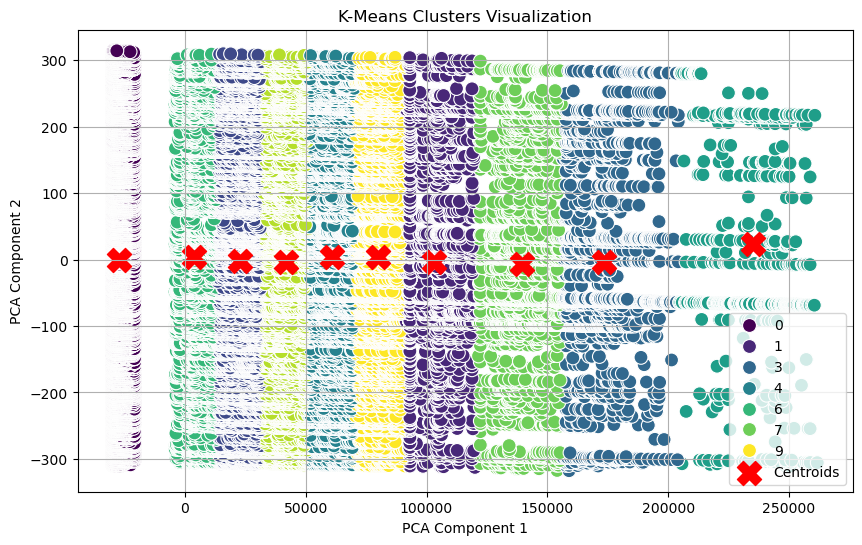

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kmeans_clusters(X_pca, kmeans_model):
    # Get the cluster labels
    labels = kmeans_model.labels_

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', s=100)
    
    # Mark the cluster centroids
    centroids = kmeans_model.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', label='Centroids', marker='X')

    plt.title('K-Means Clusters Visualization')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Apply PCA and fit KMeans (if not done already)
X_pca = apply_pca(X[['userId', 'movieId']])  # Assuming you've already done PCA
kmeans_model = cluster_users(X_pca, n_clusters=10)  # Assuming 10 clusters, but you can change this

# Plot the KMeans clusters
plot_kmeans_clusters(X_pca, kmeans_model)


/var/folders/3y/sjhjvkb50y323dc161lrjh3c0000gn/T/ipykernel_27474/1701742356.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')


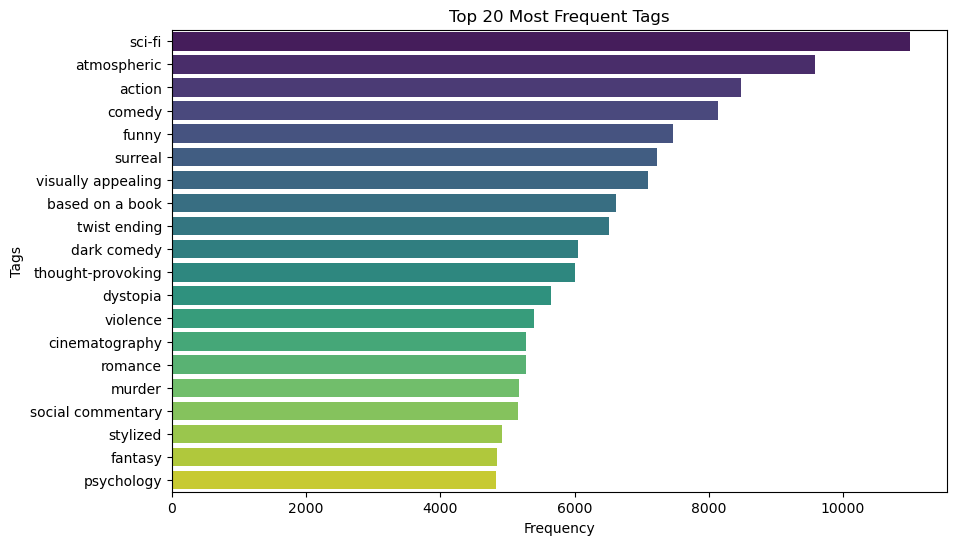

In [8]:
def plot_top_tags(tags, num_tags=20):
    top_tags = tags['tag'].value_counts().head(num_tags)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')
    plt.title(f"Top {num_tags} Most Frequent Tags")
    plt.xlabel("Frequency")
    plt.ylabel("Tags")
    plt.show()

# Call this with your tags dataframe
plot_top_tags(tags)


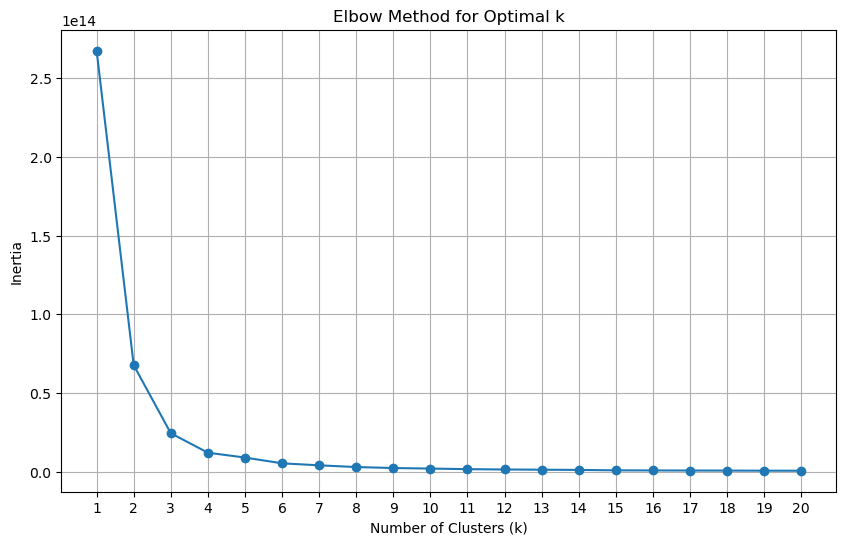

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load your data (assuming merged_data is already defined)
# For demonstration, we can use userId and movieId as features
X = merged_data[['userId', 'movieId']]

# List to hold the inertia values for each number of clusters
inertia = []

# Test different numbers of clusters
max_clusters = 20
for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

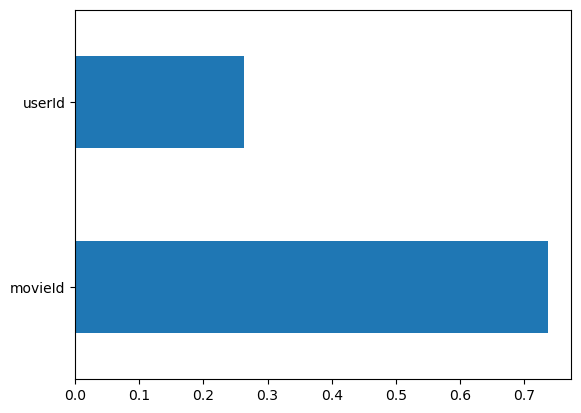

In [18]:
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()


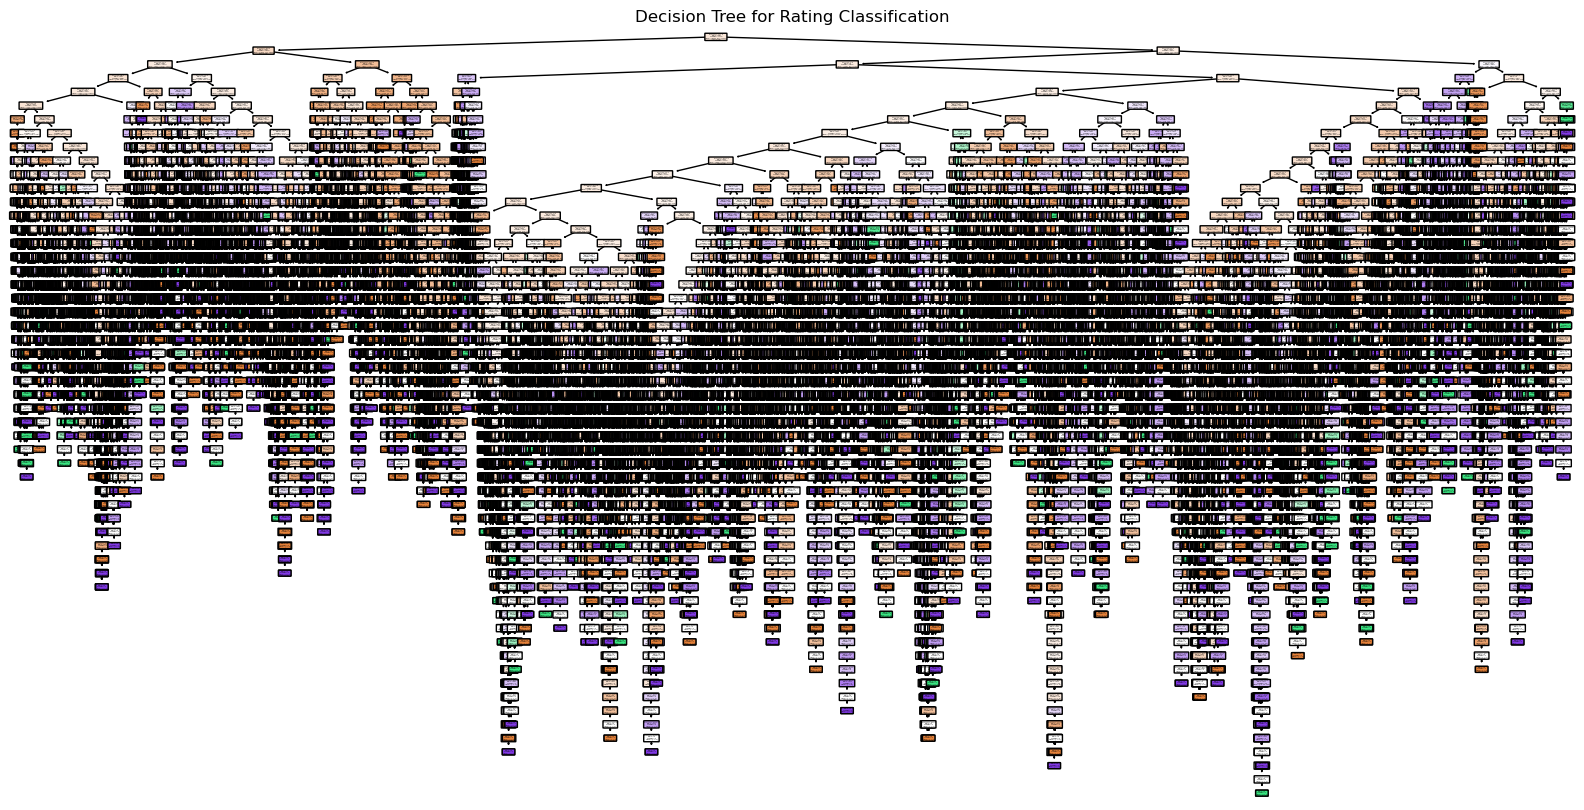

In [24]:
from sklearn import tree

plt.figure(figsize=(20, 10))
tree.plot_tree(clf, filled=True, feature_names=['userId', 'movieId'], class_names=['Low', 'Medium', 'High'], rounded=True)
plt.title('Decision Tree for Rating Classification')
plt.show()

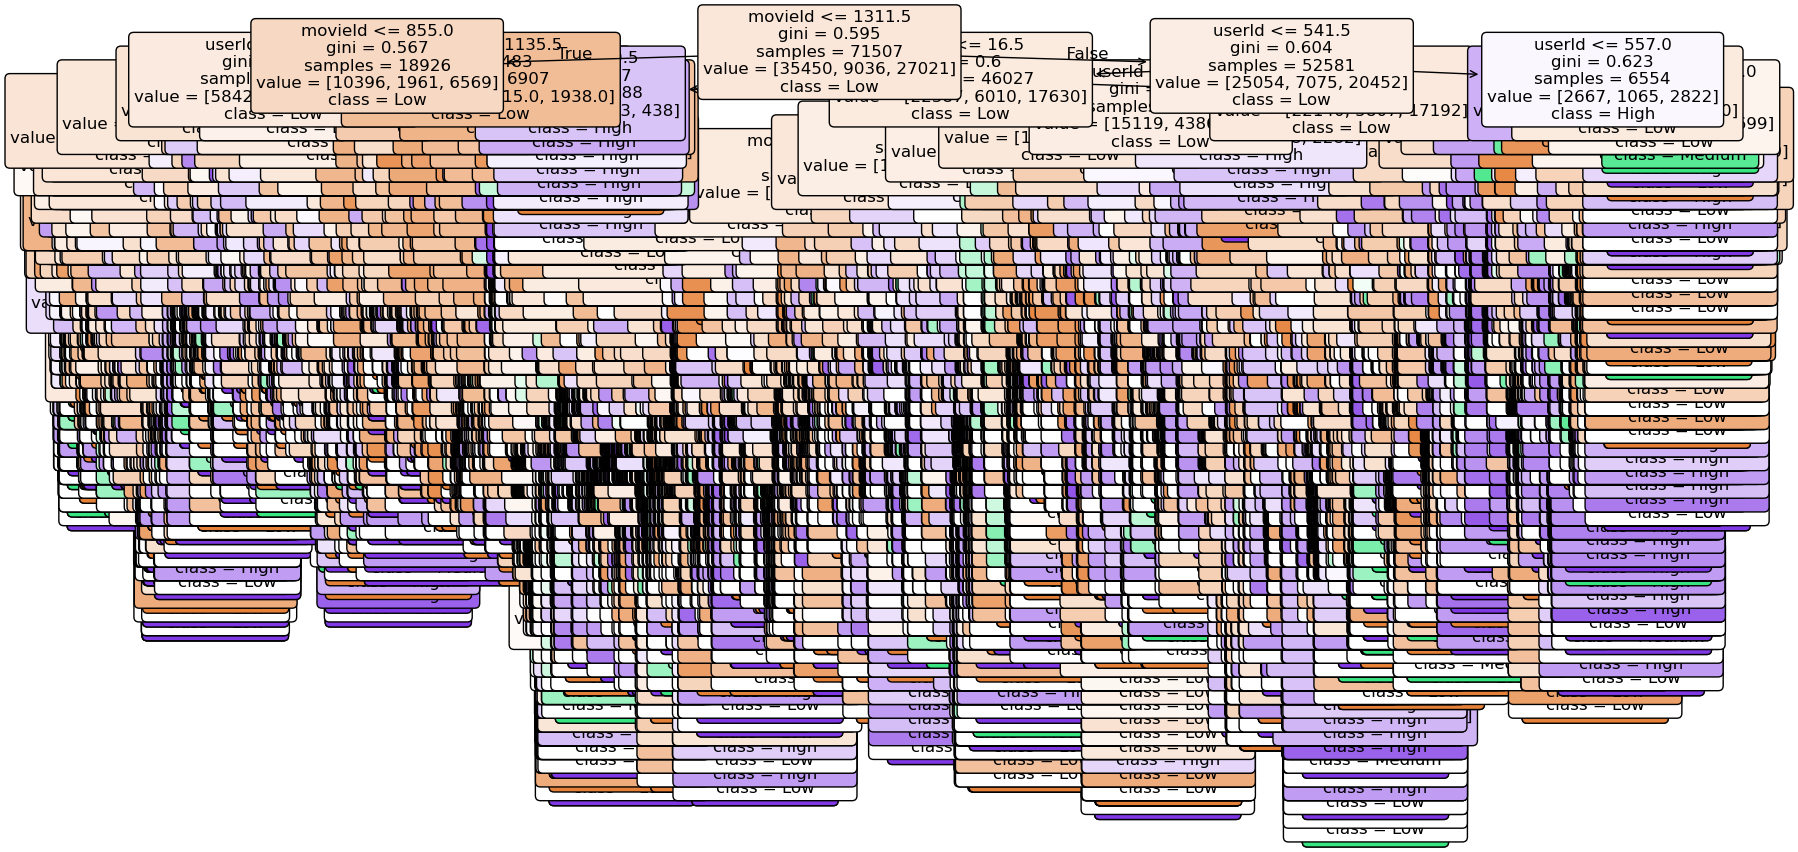

In [26]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

def visualize_decision_tree(clf, feature_names, class_names):
    plt.figure(figsize=(20, 10))  # Set the figure size for better clarity
    plot_tree(clf, feature_names=feature_names, class_names=class_names, 
              filled=True, rounded=True, fontsize=12)
    plt.show()

# Assuming 'clf' is your trained DecisionTreeClassifier
# Specify the feature names and class names for better interpretation
feature_names = ['userId', 'movieId']  # Features used for classification
class_names = ['Low', 'Medium', 'High']  # The target classes

# Visualize the decision tree
visualize_decision_tree(clf, feature_names, class_names)
